# Supervised Learning -- SVM

This notebook will going to predict KDD'99 attacks type based on the given label, using support vector machine approach (SVM). 

In [64]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
rseed = 93

In [25]:
data_cmb = pd.read_csv("dataset/kdd99_10_percent.dump.csv")
print(data_cmb.head(1))
print(data_cmb['target'].head(1))

   duration protocol_type  service   flag  src_bytes  dst_bytes  land  \
0         0        b'tcp'  b'http'  b'SF'        181       5450     0   

   wrong_fragment  urgent  hot     ...      dst_host_srv_count  \
0               0       0    0     ...                       9   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.11                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   

   dst_host_srv_rerror_rate      target  
0                       0.0  b'normal.'  

[1 rows x 42 columns]
0    b'normal.'
Name: target, dtype: object


## dataset preparation: train and test split

Here, we do **stratified sampling** based on target classes.

In [35]:
X = data_cmb.copy().drop(['target'],axis=1)
Y = data_cmb['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.25,random_state=rseed)

In [54]:
print("check class pencetage in train")
print(y_train.value_counts()*100/y_train.shape[0])
print("\ncheck class pencetage in test")
print(y_test.value_counts()*100/y_test.shape[0])

check class pencetage in train
b'smurf.'              56.837645
b'neptune.'            21.699796
b'normal.'             19.690971
b'back.'                0.445866
b'satan.'               0.321714
b'ipsweep.'             0.252351
b'portsweep.'           0.210518
b'warezclient.'         0.206469
b'teardrop.'            0.198103
b'pod.'                 0.053439
b'nmap.'                0.046692
b'guess_passwd.'        0.010796
b'buffer_overflow.'     0.005938
b'land.'                0.004318
b'warezmaster.'         0.004048
b'imap.'                0.002429
b'rootkit.'             0.002159
b'loadmodule.'          0.001889
b'ftp_write.'           0.001619
b'multihop.'            0.001349
b'phf.'                 0.000810
b'spy.'                 0.000540
b'perl.'                0.000540
Name: target, dtype: float64

check class pencetage in test
b'smurf.'              56.837724
b'neptune.'            21.699351
b'normal.'             19.691351
b'back.'                0.446132
b'satan.'         

In [6]:
X_train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
58957,0,b'tcp',b'private',b'S0',0,0,0,0,0,0,...,255,7,0.03,0.07,0.0,0.0,1.0,1.0,0.0,0.0
92403,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0
468495,0,b'tcp',b'private',b'REJ',0,0,0,0,0,0,...,255,14,0.05,0.08,0.0,0.0,0.0,0.0,1.0,1.0


In [11]:
l=[X_train, X_test, y_train, y_test]
%store l

Stored 'l' (list)


## SVM

### Data Proprocess for SVM
SVM may need to take care of followings: 
  * overfitting if features are large
  * scaling the features to [-1, 1], otherwise, SVM may hard to converge. 
  * if after scalling, SVM is still slow, we can consider to 
     1. do BaggingClassifier by sampling on small subset and perform modeling for several times. 
     2. increase cache value in SVC argument 


SVM does not support categorical feature. We can use one-hot as a preprocessor step to encode the category feature. As for SVM, we're going to work on the following models: 

1. **model1** SVM, remove category features
2. **model2** SVM, encoding category features using OneHotEncoder
3. **model3** PCA+SVM, since we have 40+ features, we'll consider to perform PCA to reduce number of features. 

In [160]:
%store -r
[X_train, X_test, y_train, y_test] = l
print("size for y_train: %s" % y_train.shape)
print("size of x_train: %s x %s" % X_train.shape)
print("size for y_test: %s" % y_test.shape)
print("size of x_test: %s x %s" % X_test.shape)

size for y_train: 370515
size of x_train: 370515 x 41
size for y_test: 123506
size of x_test: 123506 x 41


In [161]:
X_train.columns[[1,2,3]]

Index(['protocol_type', 'service', 'flag'], dtype='object')

In [42]:
from sklearn.preprocessing import MinMaxScaler
X_train_trans = X_train.drop(X_train.columns[[1,2,3]],axis=1)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_trans)
X_train_trans = scaling.transform(X_train_trans)
                                             
X_test_trans = X_test.drop(X_test.columns[[1,2,3]],axis=1)
X_test_trans = scaling.transform(X_test_trans)

## Model 1: SVM baseline

For SVM classification, there are three implementations in scikit learn packages, incuding SVC, NuSVC, LinearSVC. Here, we only domnonstrate SVM. The usage for the others are simialar.

In [75]:
import time
from sklearn import svm
time_start = time.time()
model1 = svm.SVC(kernel='linear', C=1,verbose=True,random_state=rseed,decision_function_shape="ovo").fit(X_train_trans, y_train)
print("model completed, using time %5.2f seconde" % (time.time()-time_start))

[LibSVM]model completed, using time 43.05 seconde


### Model persistant using Joblib
Joblib is said to be faster and better compression rate for Numpy serise than Pickle.  

In [76]:
from sklearn.externals import joblib
model_name = "models/model_svm_1.sav"
joblib.dump(model1,model_name)

['model1.sav']

In [110]:
print("model information:\n%s: " % model1)
print("number of labels: %d" % (model1.classes_.shape[0]))
print("cache size: %d" % model1.cache_size)
print("expected number of classes under one-vs-one model: %d" 
      % (model1.classes_.shape[0]*(model1.classes_.shape[0]-1)/2))
print("number of decisions from the model based on \'ovo\' %d" %model1.decision_function(np.arange(0,38)).shape[1])

model information:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=93, shrinking=True,
  tol=0.001, verbose=True): 
number of labels: 23
cache size: 200
expected number of classes under one-vs-one model: 253
number of decisions from the model based on 'ovo' 253


/Applications/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### Model measurement
* get accuracy, confusion matrix

accuracy based on training: 0.9988
accuracy based on testing: 0.9985



/Applications/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


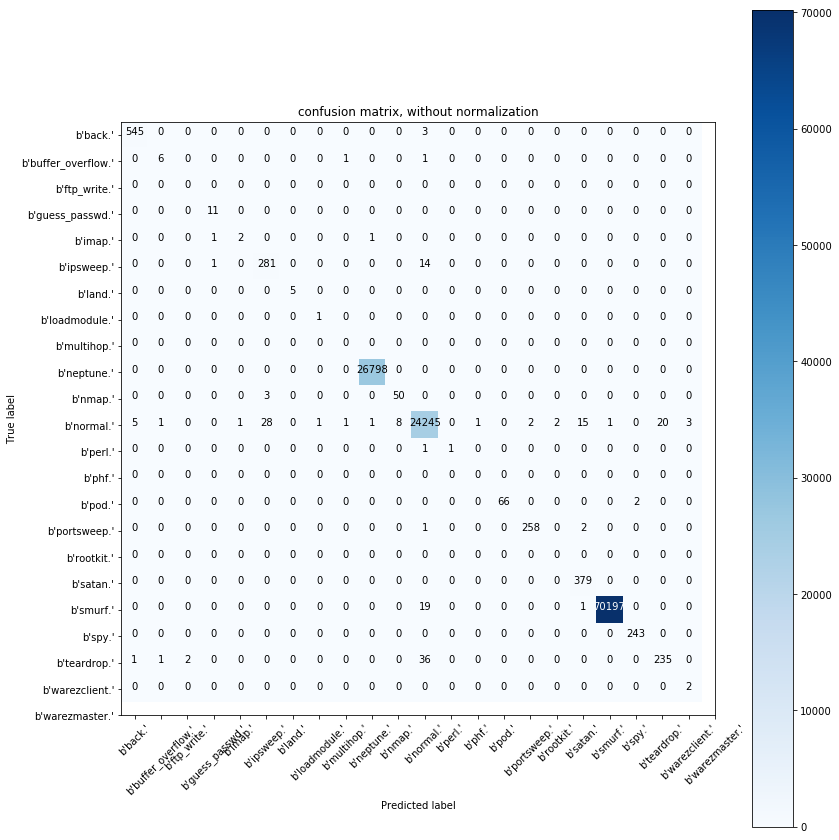

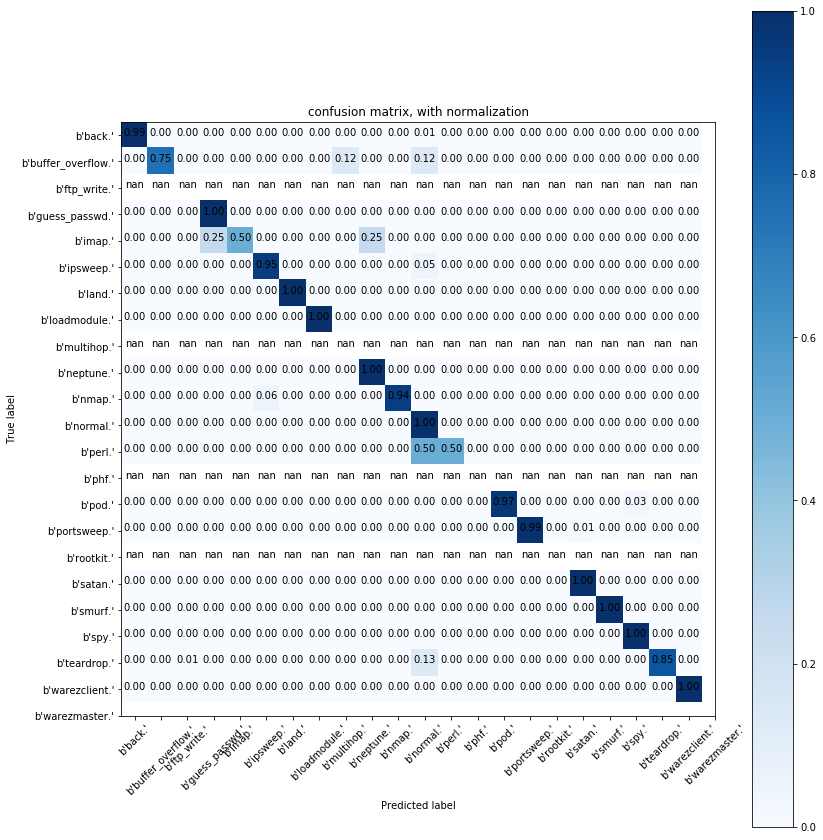

In [163]:
# compute accuracy
print("accuracy based on training: %5.4f" % model1.score(X_train_trans, y_train))  

print("accuracy based on testing: %5.4f" % model1.score(X_test_trans, y_test))  

# compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_model1 = confusion_matrix(model1.predict(X_test_trans),y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print("")
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

import numpy as np
np.set_printoptions(precision=2)

width = 12
height = 12
plt.figure(figsize=(width, height))
plot_confusion_matrix(cnf_model1, classes=model1.classes_, title="confusion matrix, without normalization")

plt.figure(figsize=(width, height))
plot_confusion_matrix(cnf_model1, classes=model1.classes_, normalize=True, title="confusion matrix, with normalization")

plt.show()

### Make prediction

In [112]:
print(model1.predict(X_test_trans[1]))
print(y_test.iloc[1])

["b'smurf.'"]
b'smurf.'


/Applications/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [113]:
model1.support_vectors_

array([[-1.        , -0.99984268, -0.99677469, ..., -1.        ,
        -0.88      , -0.88      ],
       [-1.        , -0.99984268, -0.99677469, ..., -1.        ,
        -0.94      , -0.94      ],
       [-1.        , -0.99984268, -0.99677469, ..., -1.        ,
        -0.98      , -0.98      ],
       ..., 
       [-0.99965712, -1.        ,  0.99794859, ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -0.99721422, ..., -1.        ,
        -1.        , -1.        ],
       [-0.99993142, -1.        , -0.5503415 , ..., -1.        ,
        -1.        , -1.        ]])

## Model 2: One Hot Encoder

As there are three categorical features, in Model1, we excluded it. In this section, we will use one hot encoder to trasform it into serveral binary features.  

In [164]:
%store -r
[X_train, X_test, y_train, y_test] = l
print("size for y_train: %s" % y_train.shape)
print("size of x_train: %s x %s" % X_train.shape)
print("size for y_test: %s" % y_test.shape)
print("size of x_test: %s x %s" % X_test.shape)

size for y_train: 370515
size of x_train: 370515 x 41
size for y_test: 123506
size of x_test: 123506 x 41


In [169]:
X_train.iloc[:,[1,2,3]].head()

,protocol_type,service,flag
58957,b'tcp',b'private',b'S0'
92403,b'icmp',b'ecr_i',b'SF'
468495,b'tcp',b'private',b'REJ'
347522,b'udp',b'private',b'SF'
452306,b'udp',b'domain_u',b'SF'


Both **pandas** and **scikit-learn** modules have the solutions for one-hot encoding. However, scikit-learn **OneHotEncoder** process only takes in integer labels. Therefore, an additional **LabelEncoder** is required, which is for series in nature. In this work, we use pandas **get_dummies** function as our dataset is already the pandas dataframe. 

In [179]:
X_train_dm = pd.get_dummies(X_train, columns=["protocol_type","service","flag"]).head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_b'REJ',flag_b'RSTO',flag_b'RSTOS0',flag_b'RSTR',flag_b'S0',flag_b'S1',flag_b'S2',flag_b'S3',flag_b'SF',flag_b'SH'
58957,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
92403,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
468495,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
347522,0,105,146,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
452306,219,104,45,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [197]:
X_train_dm = pd.get_dummies(X_train, columns=["protocol_type","service","flag"])
X_test_dm = pd.get_dummies(X_test, columns=["protocol_type","service","flag"])

# check if X_test_dm missed some columns, we assign to 0
missing_cols = set(X_train_dm.columns) - set(X_test_dm.columns)
for c in missing_cols:
    print(c)
    X_test_dm[c] = 0
    
# ensure the same order
X_test_dm = X_test_dm[X_train_dm.columns]

from IPython.display import display
display(X_test_dm.head(1))

service_b'pm_dump'
service_b'red_i'


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_b'REJ',flag_b'RSTO',flag_b'RSTOS0',flag_b'RSTR',flag_b'S0',flag_b'S1',flag_b'S2',flag_b'S3',flag_b'SF',flag_b'SH'
45064,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [198]:
from sklearn.preprocessing import MinMaxScaler
X_train_trans = X_train_dm
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_trans)
X_train_trans = scaling.transform(X_train_trans)
                                             
X_test_trans = X_test_dm
X_test_trans = scaling.transform(X_test_trans)

In [200]:
import time
from sklearn import svm
time_start = time.time()
model2 = svm.SVC(kernel='linear', C=1,verbose=True,random_state=rseed,decision_function_shape="ovo").fit(X_train_trans, y_train)
print("model completed, using time %5.2f seconde" % (time.time()-time_start))

[LibSVM]model completed, using time 62.77 seconde


In [202]:
from sklearn.externals import joblib
model_name = "models/model_svm_2.sav"
joblib.dump(model2,model_name)

['model2.sav']

accuracy based on training: 0.9995
accuracy based on testing: 0.9992



/Applications/anaconda/envs/py3k/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


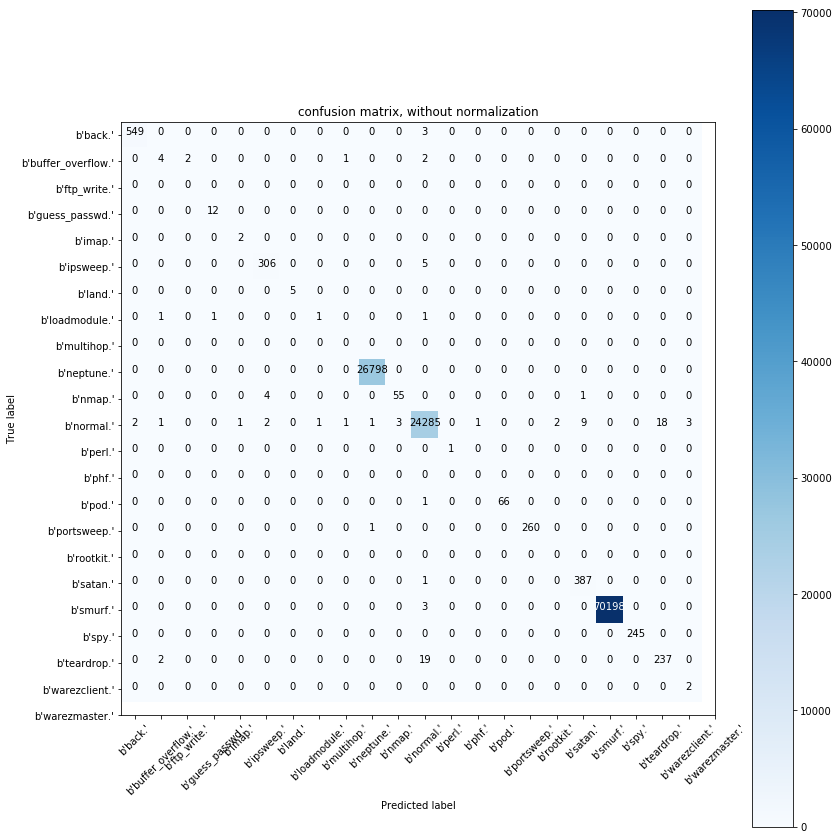

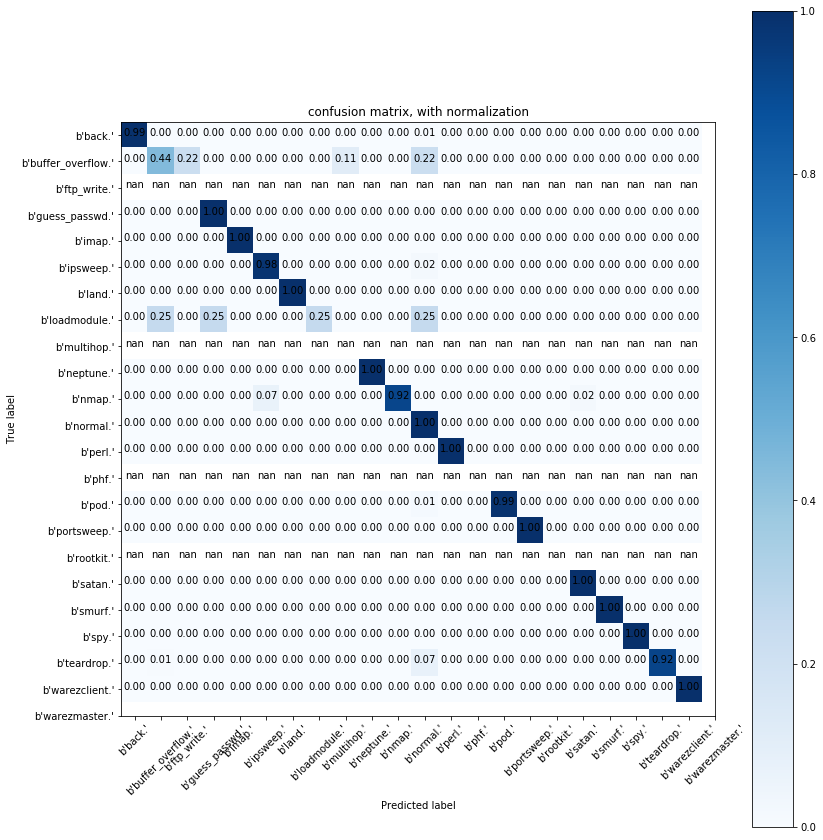

In [204]:
# compute accuracy
print("accuracy based on training: %5.4f" % model2.score(X_train_trans, y_train))  

print("accuracy based on testing: %5.4f" % model2.score(X_test_trans, y_test))  

# compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_model2 = confusion_matrix(model2.predict(X_test_trans),y_test)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print("")
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

import numpy as np
np.set_printoptions(precision=2)

width = 12
height = 12
plt.figure(figsize=(width, height))
plot_confusion_matrix(cnf_model2, classes=model2.classes_, title="confusion matrix, without normalization")

plt.figure(figsize=(width, height))
plot_confusion_matrix(cnf_model2, classes=model2.classes_, normalize=True, title="confusion matrix, with normalization")

plt.show()